# MSDS Assignment 4: Sentiment Analysis of Amazon Reviews
## Category: Video games
## Author: Ben Xiao

# Setup

In [1]:
###### Setup #######
# Import packages
import sys
import pandas as pd
import numpy as np
import os
import re, string
import nltk
import gensim
import multiprocessing
import matplotlib
import sklearn
import time
import tensorflow as tf
from tensorflow import keras

In [2]:
# Import support libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from gensim.scripts.glove2word2vec import glove2word2vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Input
from collections import OrderedDict

In [3]:
# Check package versions
print('Check package version:')
print('Python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('NumPy: {}'.format(np.__version__))
print('ReGex: {}'.format(re.__version__))
print('scikit-learn: {}'.format(sklearn.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))

Check package version:
Python: 3.8.2 (default, Apr 27 2020, 15:53:34) 
[GCC 9.3.0]
pandas: 1.0.3
NumPy: 1.18.3
ReGex: 2.2.1
scikit-learn: 0.22.2.post1
matplotlib: 3.2.1


In [4]:
# Text parsing settings
STEMMING = True
seed = 88
cores = multiprocessing.cpu_count()

# Import data

In [5]:
# Import and check data
data_path = 'data_files/short_reviews.pkl'
df = pd.read_pickle(data_path)
df.head()

,overall,reviewText,asin,word_counts
0,1,I used to play this game years ago and loved i...,0439381673,139
1,3,The game itself worked great but the story lin...,0439381673,145
2,4,I had to learn the hard way after ordering thi...,0439381673,447
3,1,The product description should state this clea...,0439381673,157
4,4,I would recommend this learning game for anyon...,0439381673,120


In [6]:
############################
# DEVELOPMENT SET - comment out when done
############################
#df = df.iloc[:2000]

## Allocate train/validate/test splits

In [7]:
# train, validate, test
fracs = np.array([0.6, 0.2, 0.2])

# shuffle dataframe rows before splitting
df = df.sample(frac=1, random_state=seed)

# split into 3 parts
train, val, test = np.array_split(
    df, (fracs[:-1].cumsum() * len(df)).astype(int))

# Global functions

In [8]:
# Function to clean text
def clean_doc(doc):
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    # filter out tokens more than 20 characters long
    tokens = [word for word in tokens if len(word) < 21]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

In [9]:
# Function to record time
def parse_time(start_time, end_time):
    runtime = end_time - start_time
    return round(runtime, 3)

# Clean docs

In [10]:
# Generate documents
train_docs = list()
val_docs = list()
test_docs = list()

In [11]:
# Clean training set
print('Start cleaning training docs...')
start_clean = time.time()
for i in range(len(train)):
    temp_text = df.reviewText.iloc[i]
    cleaned_doc = clean_doc(temp_text)

    combined_text = ' '.join(cleaned_doc)
    train_docs.append(combined_text)

end_clean = time.time()
print('Finished cleaning training docs...')
clean_runtime = parse_time(start_clean, end_clean)
print('Cleaning runtime: {}'.format(clean_runtime))
#print(docs[0])

# Clean validation set
print('Start cleaning validation docs...')
start_clean = time.time()
for i in range(len(val)):
    temp_text = df.reviewText.iloc[i]
    cleaned_doc = clean_doc(temp_text)
    combined_text = ' '.join(cleaned_doc)
    val_docs.append(combined_text)

end_clean = time.time()
print('Finished cleaning validation docs...')
clean_runtime = parse_time(start_clean, end_clean)
print('Cleaning runtime: {}'.format(clean_runtime))

# Clean test set
print('Start cleaning test docs...')
start_clean = time.time()
for i in range(len(val)):
    temp_text = df.reviewText.iloc[i]
    cleaned_doc = clean_doc(temp_text)
    combined_text = ' '.join(cleaned_doc)
    test_docs.append(combined_text)

end_clean = time.time()
print('Finished cleaning test docs...')
clean_runtime = parse_time(start_clean, end_clean)
print('Cleaning runtime: {}'.format(clean_runtime))

Start cleaning training docs...
Finished cleaning training docs...
Cleaning runtime: 0.6
Start cleaning validation docs...
Finished cleaning validation docs...
Cleaning runtime: 0.193
Start cleaning test docs...
Finished cleaning test docs...
Cleaning runtime: 0.196


# Check label distribution

In [65]:
train.overall.value_counts()

5    647
4    215
1    174
3    102
2     62
Name: overall, dtype: int64

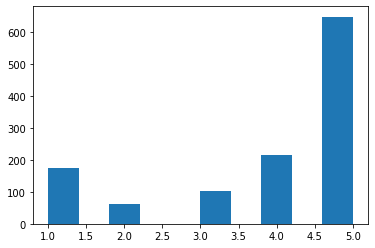

In [68]:
train.overall.hist(
    grid=False
)

In [66]:
val.overall.value_counts()

5    210
4     63
1     60
3     44
2     23
Name: overall, dtype: int64

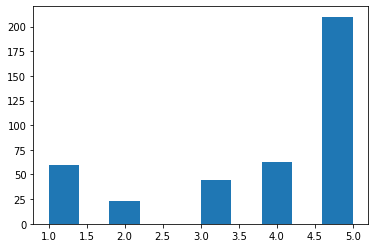

In [69]:
val.overall.hist(
    grid=False
)

In [67]:
test.overall.value_counts()

5    204
4     65
1     59
3     53
2     19
Name: overall, dtype: int64

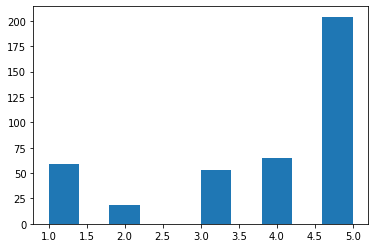

In [70]:
test.overall.hist(grid=False)

# TF-IDF - 100 dimension, 2-gram

In [12]:
ndim = 100
n_grams = 2

# 1. TF-IDF
tfidf100 = TfidfVectorizer(ngram_range=(1, n_grams),
                                max_features=ndim)
tfidf100_train_matrix = tfidf100.fit_transform(train_docs)
tfidf100_val_matrix = tfidf100.transform(val_docs)
tfidf100_test_matrx = tfidf100.transform(test_docs)

In [13]:
#{k: v for k, v in sorted(tfidf_100.vocabulary_.items(), key=lambda item: item[1], reverse=True)}

# TF-IDF 200 dimension, 1-gram

In [14]:
tfidf200 = TfidfVectorizer(max_features=200) # default n-gram is 1
tfidf200_train_matrix = tfidf200.fit_transform(train_docs)
tfidf200_val_matrix = tfidf200.transform(val_docs)
tfidf200_test_matrix = tfidf200.transform(test_docs)

# GloVe - 100 dimension

Tutorial: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [44]:
# Required packages
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding

In [45]:
glove100_path = 'glove.6B/glove.6B.100d.txt'
ndim = 100
glove100_embeddings_index = {}
with open(glove100_path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove100_embeddings_index[word] = coefs

print('Found %s word vectors.' % len(glove100_embeddings_index))

Found 400000 word vectors.


In [46]:
texts = list()
tokenizer = Tokenizer(nb_words = 100)
tokenizer.fit_on_texts(train_docs)
sequences = tokenizer.texts_to_sequences(train_docs)
data = pad_sequences(sequences, maxlen=100)
word_index = tokenizer.word_index
len(word_index)

glove100_test = tokenizer.texts_to_sequences(test_docs)
glove100_val = tokenizer.texts_to_sequences(val_docs)

In [47]:
# Required or to_categorical creates 6 labels
#labels = np.asarray(df.overall.apply(lambda x: x-1))
glove_train_labels = np.asarray(train.overall.apply(lambda x: x-1))
glove_val_labels = np.asarray(val.overall.apply(lambda x: x-1))
glove_test_labels = np.asarray(test.overall.apply(lambda x: x-1))


glove_train_labels = to_categorical(glove_train_labels, num_classes=5) # number of classes, 1-5 ratings
glove_val_labels = to_categorical(glove_val_labels, num_classes=5) # number of classes, 1-5 ratings
glove_test_labels = to_categorical(glove_test_labels, num_classes=5) # number of classes, 1-5 ratings

In [48]:
data.shape, glove_train_labels.shape, glove_val_labels.shape, glove_test_labels.shape

((1200, 100), (1200, 5), (400, 5), (400, 5))

In [49]:
glove100_embedding_matrix = np.zeros((len(word_index) + 1, ndim))
for word, i in word_index.items():
    embedding_vector = glove100_embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        glove100_embedding_matrix[i] = embedding_vector

In [52]:
from tensorflow.keras.layers import Embedding

glove100_embedding_layer = Embedding(len(word_index) + 1,
                            ndim,
                            weights=[glove100_embedding_matrix],
                            input_length=100,
                            trainable=False)

In [56]:
# sequence_input = Input(shape=(100,), dtype='int32')
# embedded_sequences = glove100_embedding_layer(sequence_input)


In [58]:
glove100_embedding_layer.get_weights()[0][2]

array([ 0.062659,  0.026003,  1.122   , -0.84123 , -0.56907 ,  0.86677 ,
        0.99235 , -0.19032 , -0.74226 , -0.29547 ,  0.037746, -0.71756 ,
       -0.44891 , -0.65801 ,  0.17469 ,  0.50347 ,  0.21268 ,  1.0438  ,
       -0.60034 ,  0.48838 ,  0.16955 , -0.070132, -0.070228,  0.50193 ,
        1.3543  , -0.27193 , -0.16449 ,  0.37399 , -0.14291 ,  0.19646 ,
       -0.80925 ,  0.86245 , -0.2118  , -0.074321,  0.38522 , -0.34137 ,
       -1.2694  ,  0.59967 , -0.84746 , -0.68818 ,  0.68874 , -0.19769 ,
        0.2064  , -0.20387 , -0.33651 ,  0.093972,  0.34192 , -0.68139 ,
        0.61451 , -0.88127 , -0.13401 , -0.088989, -0.098916,  0.73405 ,
        0.33496 , -3.1068  , -0.22643 , -0.21568 ,  1.3375  ,  1.5472  ,
       -1.2343  ,  0.42964 , -0.78932 , -0.027462,  0.34738 ,  0.17338 ,
        0.24975 , -0.010451, -0.71149 ,  0.55568 , -0.20869 ,  0.074445,
        0.29833 , -0.029668, -0.01595 ,  0.46368 , -0.80873 ,  0.11564 ,
       -0.14607 ,  0.73785 ,  0.33548 ,  0.18176 , 

In [24]:
# Export weights
#np.save('data_files/glove100_weights.npy', embedding_matrix)

# Glove 200 dimension

In [59]:
ndim = 200

In [60]:
glove200_path = 'glove.6B/glove.6B.200d.txt'
glove200_embeddings_index = {}
with open(glove200_path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove200_embeddings_index[word] = coefs

print('Found %s word vectors.' % len(glove200_embeddings_index))

Found 400000 word vectors.


In [61]:
texts = list()
tokenizer = Tokenizer(nb_words = ndim)
tokenizer.fit_on_texts(train_docs)
sequences = tokenizer.texts_to_sequences(train_docs)
data = pad_sequences(sequences, maxlen=ndim)
word_index = tokenizer.word_index
len(word_index)

glove200_test = tokenizer.texts_to_sequences(test_docs)
glove200_val = tokenizer.texts_to_sequences(val_docs)

# Reuse glove train/val/test labels

In [62]:
print(len(word_index))

4200


In [63]:
glove200_embedding_matrix = np.zeros((len(word_index) + 1, ndim))
for word, i in word_index.items():
    embedding_vector = glove200_embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        glove200_embedding_matrix[i] = embedding_vector

In [64]:
glove_200_embedding_layer = Embedding(len(word_index) + 1,
                            ndim,
                            weights=[glove200_embedding_matrix],
                            input_length=100,
                            trainable=False)

glove_100_embedding_layer and glove_200_embedding_layer are now layers that go in as training layers.